# This is a notebook analyzing breast cancer data of scikit-learn library
   1. conducting exploratory analysis of the data
   2. implementing binary classification using K-nearest neighbors Classifiers Algorithm (knn), and detecting if the neoplasom is benign or malignant (supervised classification algorithm)
   3. implementing K-means clustering to predict if the neoplasom is benign or malignant (unsupervised classification algorithm)

In [90]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import datasets, neighbors
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline

## Conducting exploratory analysis to understand the trend, pattern, and distribution of the raw data

__1. load in cancer data__

In [4]:
cancer = datasets.load_breast_cancer()

__2. summary of bunch object__

In [23]:
cancer.DESCR

'.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry\n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        worst/largest values) of these features were computed for each image,\n        resulting in 30 features.  For inst

__3. summary of the cancer data__

In [ ]:
print("a. The cancer data contains {} observations and {} features".format(cancer.data.shape[0], cancer.data.shape[1]))
print("b. There are {} features".format(cancer.feature_names))
print("c. Sample size for each category:{}".format({name:count for name, count in zip(cancer.target_names, np.bincount(cancer.target))}))

__4. extract data and convert to dataframe__

In [5]:
cancer_dataframe = pd.DataFrame(cancer.data, columns = cancer.feature_names)
cancer_dataframe["target"] = cancer.target.tolist()
cancer_dataframe["target"] = cancer_dataframe["target"].apply(str)
cancer_dataframe.head()
#add target_name
target_dict = {"1": "benign", "0": "malignant"}
cancer_dataframe["target_name"] = cancer_dataframe["target"].map(target_dict)

__5. build App to plot relationship between features and/or target categories__

In [ ]:
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Relationship between features and/or targets"),
    dcc.Graph(id="scatterplots"),
    html.Label([
        "Features_x",
        dcc.Dropdown(
            id="Features_x", clearable=False,
            options=[{"label": col, "value": col} for col in cancer_dataframe.columns.drop("target")])
    ]),
    html.Label([
        "Features_y",
        dcc.Dropdown(
            id="Features_y", clearable=False,
            options=[{"label": col, "value": col} for col in cancer_dataframe.columns.drop("target")])
    ]),
])
#Define callback to update graph
@app.callback(
    Output("scatterplots", "figure"),
    [Input("Features_x", "value"),
     Input("Features_y", "value")])

#define scatterplot plotting function 
def scatter_plots(column1, column2):
    return px.scatter(cancer_dataframe.drop(columns = "target"),
                     x = column1, y = column2, color = "target_name",
                     render_mode = "WebGL",
                     title = "<b>{}</b> vs. <b>{}</b>".format(column1,column2))
#run app and diplay scatterplots
app.run_server()

## Classification Methods
__1. Since the training data is labeled, we can implement K-Nearest Neighbors (KNN) Algorithm to classify newly added observations. KNN is one of the most commonly used supervised machine learning algorithm, and observation will be assign to a class that have most common neighobors among the K (K >= 1) nearest neighbors. KNN is easy to interprete but is restrictive on sample size. Its efficiency would decrease as sample size getting large.__

In [16]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split
# test sample size is 25% as default, and the splited sample keep the proportion of classes as raw data
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 11, stratify = cancer.target) 

__IN KNN algorithm, we can apply same or different weights to neighbor points, and it mainly depends on the distribution of the data. If the predicted event has the exact same possibility of happening meaning that the random variable follows a uniform distribution. Under this circumstance, we can safely apply "uniform" weight to all neighbors no matter how far they are from the predicted point. Otherwise, it would be better to proportionally assign weights to neighbor points as their distance from the query point. In this excercise, I will stick with 'uniform' weight. Also, as the relationship plots between features, I've noticed that the features are on different scales, so I choose distance metric as mahalanobis to allow fair comparison.__


In [17]:
#set potential value for nearest neighbors
n_neighbors = range(1, 11,1)
#keep track of the training accuracy and test accuracy
accuracy = pd.DataFrame(columns = ["K_nearest_neighbors", "training_accuracy", "test_accuracy"]) 
#create classificier instance 
for k in n_neighbors:
    # calculate covariance for mahalanobis distance, referring to https://github.com/yzhao062/pyod/blob/development/examples/knn_mahalanobis_example.py
    X_train_cov = np.cov(X_train, rowvar=False)
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, metric = 'mahalanobis',  metric_params={'VI': X_train_cov})
    #fit the data
    knn.fit(X_train, y_train)
    #keep track of accuracy
    this_data = {"K_nearest_neighbors": k, "training_accuracy": knn.score(X_train, y_train), "test_accuracy": knn.score(X_test, y_test)}
    accuracy = accuracy.append(this_data, ignore_index = True)
accuracy

,K_nearest_neighbors,training_accuracy,test_accuracy
0,1.0,1.000000,0.895105
1,2.0,0.955399,0.867133
2,3.0,0.938967,0.916084
3,4.0,0.938967,0.916084
4,5.0,0.929577,0.930070
5,6.0,0.934272,0.930070
6,7.0,0.924883,0.930070
7,8.0,0.920188,0.930070
8,9.0,0.920188,0.923077
9,10.0,0.920188,0.923077


__Plot training accuracy anc test accuracy__

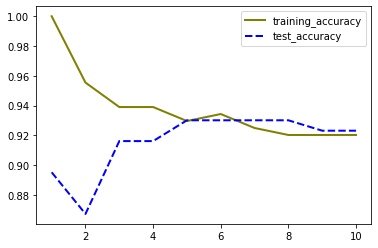

In [18]:
plt.plot( "K_nearest_neighbors", "training_accuracy", data= accuracy, linewidth=2, color='olive',linestyle='solid')
plt.plot( "K_nearest_neighbors", "test_accuracy", data= accuracy, linewidth=2, color='blue',linestyle='dashed')
plt.legend()

__Plot decision boundaries for testing set when k equals to 3, 6, 9 for selected features__

In [91]:

#define scatterplot plotting function 
def decision_boundary(ax, k, Features_x, Features_y):
    ax = ax
    X = cancer_dataframe[[Features_x, Features_y]]
    y = cancer_dataframe.target
    X_cov = np.cov(X, rowvar=False)
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, metric = 'mahalanobis',  metric_params={'VI': X_cov})
    #fit the data
    knn.fit(X, y)
    
    #Plot the decision boundary
    #define the boundary of the mesh
    h = .02  # step size in the mesh
    # define coordinates
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    #define height value for the filled contour plot 
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    Z = Z.reshape(xx.shape)
    #plot contours
    cmap = cm = plt.get_cmap('Pastel2') 
    ax.contourf(xx, yy, Z,cmap=cmap, alpha = 0.5)
    
    ax.set_xlabel(Features_x)
    ax.set_ylabel(Features_y) 
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    colors = {'malignant':cmap.colors[0], 'benign':cmap.colors[2]}

    #Plot the data points
    scatter = ax.scatter(x = cancer_dataframe.drop(columns = "target")[Features_x],  y= cancer_dataframe.drop(columns = "target")[Features_y], 
                c = cancer_dataframe.drop(columns = "target")['target_name'].map(colors), edgecolor="black", label = cancer_dataframe.drop(columns = "target")['target_name'])
    ax.set_title('{} neighbors'.format(k))
    a = mpatches.Patch(color=cmap.colors[0], label='malignant')
    b = mpatches.Patch(color=cmap.colors[2], label='benign')

    ax.legend(handles=[a,b])


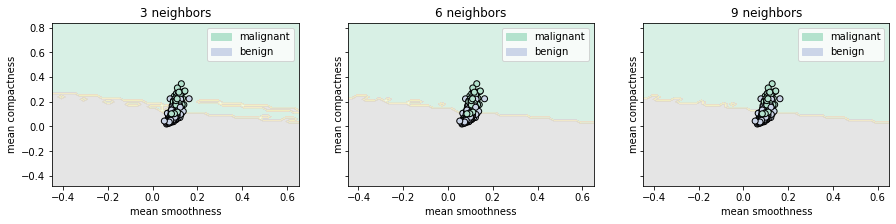

In [92]:
fig, axes = plt.subplots(1,3, figsize = (15, 3), sharey= True)
for k, ax in zip([3,6,9], axes):
   decision_boundary(ax = ax, k = k, Features_x = 'mean smoothness', Features_y = 'mean compactness')
   